# Лабораторная работа 4. Исследование эффективности применения общего и раздельного структурного резервирования для повышения надёжности систем


Вариант 12

Лазарев Эдуард Артемович
N33471

## Схема системы

![system diagram](system_diagram.png)

## Формулы рассчёта функции надёжности системы

Расчитаем функцию надёжности системы, декомпозируя её на участки с последовательным и параллельным соединением:

$$
\begin{align*}
    p(t) &= p_1(t)p_{2-7}(t) \\
    p_{2-7}(t) &= 1 - q_{2,4,6}(t)q_{3,5,7}(t) = 1 - (1 - p_{2,4,6}(t))(1 - p_{3,5,7}(t)) \\
    p_{2,4,6}(t) &= p_2(t)p_4(t)p_6(t) \\
    p_{3,5,7}(t) &= p_3(t)p_5(t)p_7(t)
\end{align*}
$$

В конечном итоге функция надёжности системы из варианта примет вид:
$$
p(t) = p_1(t)(1 - (1 - p_2(t)p_4(t)p_6(t))(1 - p_3(t)p_5(t)p_7(t))
$$

In [1]:
from matplotlib import pyplot as plt
from scipy import integrate
from itertools import product
import numpy as np

Введём начальные значения для данного варианта.

In [2]:
# Варианты кратности резервирования
M = (1, 2, 3)

# Интенсивности отказов элементов.
Lambdas = np.array([9, 8, 7, 1, 3, 2, 1]) * 10 ** -5


Определим функцию обёртку, возращающую функцию надёжности одного элемента системы, и функцию обёртку, возращающую надёжности всей системы.

In [3]:
def get_p(lambda_: float, m: int = 0):
    """Функция обёртка для создания функции надёжности элемента."""
    
    def p(t: float):
        """Функция надёжности элемента."""
        return 1 - (1 - np.exp(-lambda_ * t)) ** (m + 1)
    
    return p

def get_p_c(lambdas: list, type_: int = 0, m: int = 0):
    """Функция обёртка для создания функции надёжности всей системы."""

    def p_c(t: float):
        """Функция надёжности системы."""
        if type_ == 2:
            p_i = [get_p(lambda_, m) for lambda_ in lambdas]
        else:
            p_i = [get_p(lambda_) for lambda_ in lambdas]

        return p_i[0](t) * (1 - (1 - p_i[1](t) * p_i[3](t) * p_i[5](t)) * (1 - p_i[2](t) * p_i[4](t) * p_i[6](t)))

    if type_ == 1:
        return lambda t: 1 - (1 - p_c(t)) ** (m + 1)
    
    return p_c

Выполним расчёты для разных типов и красностей резервирования.

Выигрыш по средней наработке на отказ при общем резервировании, красности 1: 1.4
Выигрыш по средней наработке на отказ при общем резервировании, красности 2: 1.7
Выигрыш по средней наработке на отказ при общем резервировании, красности 3: 1.9
Выигрыш по средней наработке на отказ при раздельном резервировании, красности 1: 1.9
Выигрыш по средней наработке на отказ при раздельном резервировании, красности 2: 2.5
Выигрыш по средней наработке на отказ при раздельном резервировании, красности 3: 2.9


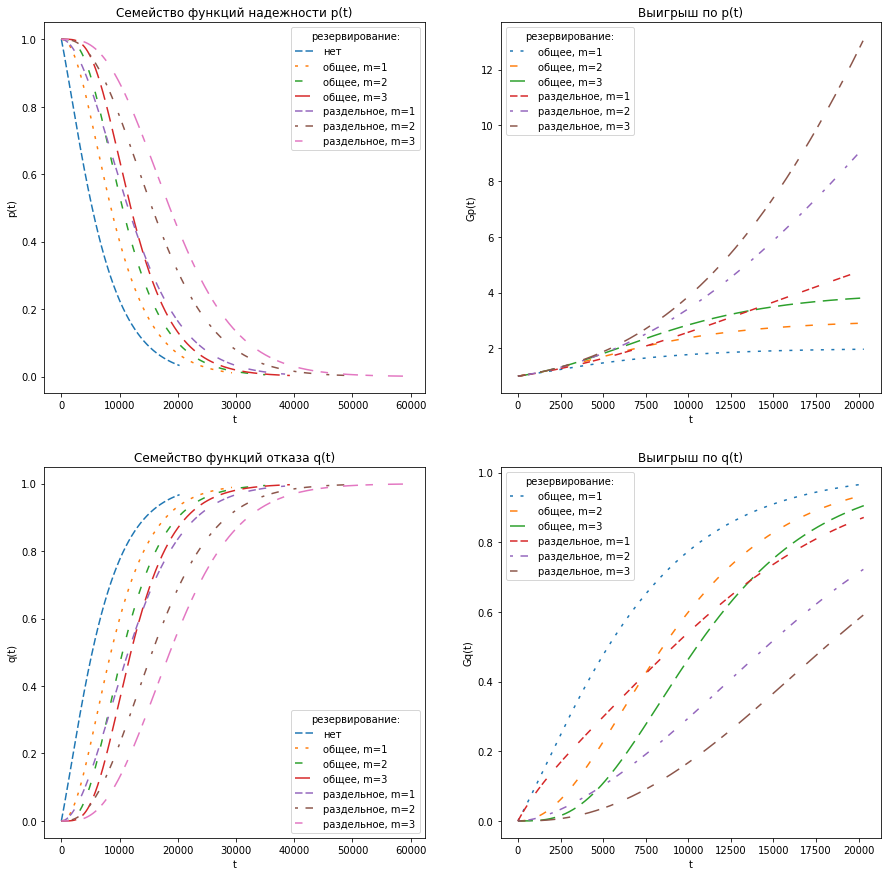

In [4]:
dash_list = [(5, 2), (2, 5), (5, 10), (10, 5), (5, 2, 5, 10), (2, 5, 5, 10), (5, 10, 10, 5)]

fig, axs = plt.subplots(2, 2, figsize=(15,15))

axs[0][0].set_title('Семейство функций надежности p(t)')
axs[0][0].set_xlabel('t')
axs[0][0].set_ylabel('p(t)')

axs[1][0].set_title('Семейство функций отказа q(t)')
axs[1][0].set_xlabel('t')
axs[1][0].set_ylabel('q(t)')

axs[0][1].set_title('Выигрыш по p(t)')
axs[0][1].set_xlabel('t')
axs[0][1].set_ylabel('Gp(t)')

axs[1][1].set_title('Выигрыш по q(t)')
axs[1][1].set_xlabel('t')
axs[1][1].set_ylabel('Gq(t)')

p_c_without = get_p_c(Lambdas)
T_c_without = integrate.quad(p_c_without, 0, np.inf)[0]

xs_without = np.arange(0, T_c_without * 3, T_c_without * 3 / 1000)
p_cs = [p_c_without(t) for t in xs_without]
q_cs = [1 - p_c_without(t) for t in xs_without]

axs[0][0].plot(xs_without, p_cs, dashes=dash_list[0])
axs[1][0].plot(xs_without, q_cs, dashes=dash_list[0])

legend = ["нет"]

for idx, (type_, m) in enumerate(product([1, 2], M), 1):
    p_c = get_p_c(Lambdas, type_, m)
    T_c = integrate.quad(p_c, 0, np.inf)[0]

    xs = np.arange(0, T_c * 3, T_c * 3 / 1000)
    p_cs = [p_c(t) for t in xs]
    q_cs = [1 - p_c(t) for t in xs]

    Gp_cs = [p_c(t) / p_c_without(t) for t in xs_without]
    Gq_cs = [0] + [(1 - p_c(t)) / ((1 - p_c_without(t))) for t in xs_without[1:]]

    axs[0][0].plot(xs, p_cs, dashes=dash_list[idx])
    axs[1][0].plot(xs, q_cs, dashes=dash_list[idx])
    
    axs[0][1].plot(xs_without, Gp_cs, dashes=dash_list[idx])
    axs[1][1].plot(xs_without, Gq_cs, dashes=dash_list[idx])
    
    if type_ == 1:
        print(f"Выигрыш по средней наработке на отказ "
              f"при общем резервировании, красности {m}: {T_c/T_c_without:.2}")
        legend.append(f"общее, m={m}")
    if type_ == 2:
        print(f"Выигрыш по средней наработке на отказ "
              f"при раздельном резервировании, красности {m}: {T_c/T_c_without:.2}")
        legend.append(f"раздельное, m={m}")

axs[0][0].legend(legend, title='резервирование:')
axs[1][0].legend(legend, title='резервирование:')
axs[0][1].legend(legend[1:], title='резервирование:')
axs[1][1].legend(legend[1:], title='резервирование:')

for ax in [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]:
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"images/{ax.title.get_text()}.png", bbox_inches=extent.expanded(1.1, 1.2))
